In [31]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
from qiskit.visualization import plot_histogram
import numpy as np
from qiskit_aer import Aer

In [22]:
def teleportation_circuit(state_vector):
    # Create a Quantum Circuit with 3 qubits and 2 classical bits
    circuit = QuantumCircuit(3, 2)

    # Prepare the state to be teleported (|psi>)
    circuit.initialize(state_vector, 0)

    # Create entanglement between qubit 1 and qubit 2
    circuit.h(1)  # Apply Hadamard gate to qubit 1
    circuit.cx(1, 2)  # Apply CNOT gate to entangle qubits 1 and 2
    circuit.barrier()

    # Bell measurement
    circuit.cx(0, 1)
    circuit.h(0)
    circuit.barrier()
    
    circuit.measure(0, 0)  # Measure qubit 0
    circuit.measure(1, 1)  # Measure qubit 1

    # Apply corrections based on measurement results
    circuit.x(2).c_if(circuit.clbits[1], 1)  # Apply X gate if the second measurement is 1
    circuit.z(2).c_if(circuit.clbits[0], 1)  # Apply Z gate if the first measurement is 1

    return circuit

In [23]:
# Example state |psi> = 1/sqrt(2) (|0> + |1>)
state_vector = [1/np.sqrt(2), 1/np.sqrt(2)]  # |+> state

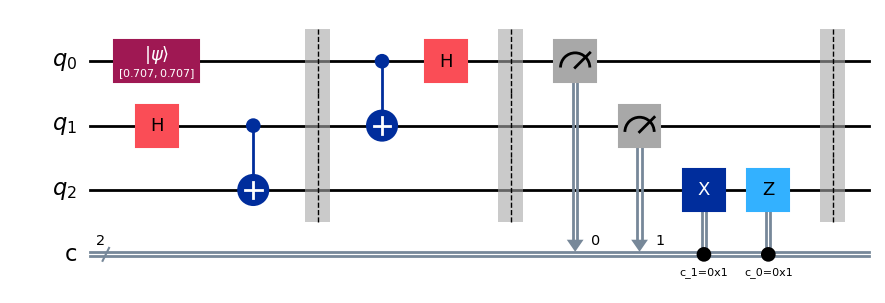

In [24]:
# Create the teleportation circuit
circuit = teleportation_circuit(state_vector)

# Draw the circuit with barriers for visual separation
circuit.barrier()
circuit.draw('mpl')

Output counts: {'00': 254, '01': 282, '11': 241, '10': 247}


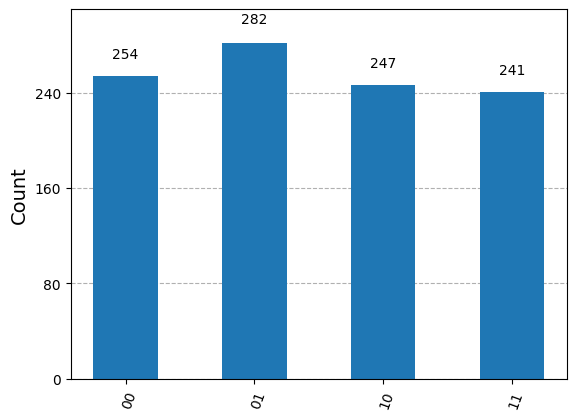

In [25]:
simulator = Aer.get_backend('qasm_simulator')
job = simulator.run(circuit, shots=1024)
result = job.result()

# Execute the circuit on the qasm simulator
result = simulator.run(circuit, shots=1024).result()

# Get the counts (output)
counts = result.get_counts()

# Print the output counts
print("Output counts:", counts)

# Plot the histogram of results
plot_histogram(counts)

In [38]:
# Define a function to test the teleportation circuit with a given initial state
def test_teleportation(initial_state):
    qc = teleportation_circuit(initial_state)
    # Execute the circuit
    simulator = Aer.get_backend('statevector_simulator')
    result = simulator.run(qc).result()
    final_state = Statevector(result.get_statevector(qc))

 # Convert Statevector to DensityMatrix for partial trace
    density_matrix = DensityMatrix(final_state)
    # Perform partial trace over qubits 0 and 1 to isolate qubit 2
    teleported_state = partial_trace(density_matrix, [0, 1])  # Trace out Q and A

    # Convert the initial state to a Statevector for comparison
    original_state = DensityMatrix(Statevector(initial_state))

    # Output the result
    print("Initial State:", original_state)
    print("Teleported State:", teleported_state)
   
   #Check if the teleported state is close to the original state
    success = np.allclose(teleported_state.data, original_state.data, atol=1e-5)
    return qc, success

In [39]:
# Example of state vectors to teleport
initial_states = [
    [1, 0],  # |0⟩
    [0, 1],  # |1⟩
    [1/np.sqrt(2), 1/np.sqrt(2)],  # |+⟩
    [1/np.sqrt(2), -1/np.sqrt(2)],  # |-⟩
]

# Test the teleportation for each state
for state in initial_states:
    qc, success = test_teleportation(state)
    qc.draw(output='mpl')  # Display the circuit
    print("Teleportation Successful:", success)

Initial State: DensityMatrix([[1.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j]],
              dims=(2,))
Teleported State: DensityMatrix([[1.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j]],
              dims=(2,))
Teleportation Successful: True
Initial State: DensityMatrix([[0.+0.j, 0.+0.j],
               [0.+0.j, 1.+0.j]],
              dims=(2,))
Teleported State: DensityMatrix([[0.+0.j, 0.+0.j],
               [0.+0.j, 1.+0.j]],
              dims=(2,))
Teleportation Successful: True
Initial State: DensityMatrix([[0.5+0.j, 0.5+0.j],
               [0.5+0.j, 0.5+0.j]],
              dims=(2,))
Teleported State: DensityMatrix([[0.5+0.00000000e+00j, 0.5+6.12323400e-17j],
               [0.5-6.12323400e-17j, 0.5-2.79557852e-33j]],
              dims=(2,))
Teleportation Successful: True
Initial State: DensityMatrix([[ 0.5+0.j, -0.5-0.j],
               [-0.5+0.j,  0.5+0.j]],
              dims=(2,))
Teleported State: DensityMatrix([[ 0.5+0.00000000e+00j, -0.5-6.12323400e-17j],
      